<a href="https://colab.research.google.com/github/orudda/Wang-Landau-algorithm/blob/main/Wang_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import random, math, pylab

#Cod fonte

In [ ]:
@jit(nopython=True)
def estado_ini(N):
    #Gera um estadon inicial aleatório para rede
    s = np.zeros(N,dtype=np.int8)
    for i in range(N):
        s[i] = np.sign(2*np.random.random()-1)
    return s

@jit(nopython=True)
def vizinhos(L,N):
    #Define a tabela de vizinhos 
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L 
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1 
        if k % L == 0: viz[k,2] = k+L-1
        viz[k,3] = k-L 
        if k < L: viz[k,3] = k+N-L
    return viz

@jit(nopython=True)
def energia(s, viz, N):
    #Calcula a energia da configuração s
    ener = 0 
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]]
        ener -= s[i]*h
    ener = int((ener+2*N)/4)
    return ener

@jit(nopython=True)
def minh(H, N):
    #Calcula o menor valor de H excluindo as energias proibidas
    minh=H[0]does not support option: 'nopresultython'
    for i in range(2,N-1):
        if H[i] < minh: minh=H[i]
    if H[-1] < minh: minh=H[-1]
    return minh

@jit(nopython=True)
def wang_landau(L,N,Niter,flatness):
    # Algoritmo de Wang-Landau
    s = estado_ini(N)
    lnge = np.zeros(N+1,dtype=np.float64)
    H = np.zeros(N+1,dtype=np.int16)
    Hc = np.zeros(N+1,dtype=np.int16)
    mmicro = np.zeros(N+1,dtype=np.float64)
    lnf = 1.0
    m = s.sum()
    viz = vizinhos(L,N)
    ener = energia(s, viz, N)

    for it in range(Niter):
        #Iterações do algoritmo
        for imc in range(N):
            #Passo de Monte Carlo - percorre toda a rede
            k = np.random.randint(0,N-1)
            h = s[viz[k,0]]+s[viz[k,1]]+s[viz[k,2]]+s[viz[k,3]] # soma dos vizinhos
            ener2 = ener + int(s[k]*h*0.5)
            #print(lnge[ener]-lnge[ener2])
            if lnge[ener]>lnge[ener2]:
                s[k] = -s[k] 
                ener = ener2
                m -= 2*s[k]
            else:
                p = np.exp(lnge[ener]-lnge[ener2])
                if np.random.random() < p: 
                    s[k] = -s[k] 
                    ener = ener2
                    m -= 2*s[k]
            H[ener] += 1
            lnge[ener] += lnf
            mmicro[ener] += abs(m)
        if it%1000 == 0:
            hmed = float(H.sum())/float((N-1))
            hmin = minh(H, N)
            if hmin > (flatness*hmed):
                Hc += H
                H = np.zeros(N+1,dtype=np.int16)
                lnf = 0.5*lnf
                print("Histograma flat!",lnf)
            if it%1000000 == 0: print("Iteração número",it)
        if lnf < 0.00000001: break
        
    mmicro = mmicro/Hc
    lnge = lnge - lnge[0]+np.log(2)
    return lnge,mmicro,ener,s


def media_termodinamica(g,lista,beta,n):
    maxi = max(g)
    g = np.exp(g-maxi)
    z=0
    e_i = 0
    e_ii = 0
    eMin = min(lista)
    
    for e in lista:
        e_1 = (4*e-2*n) - (4*eMin-2*n)
        z = z + (g[e]*np.exp(-beta*e_1))
        e_i = e_i + (e_1*g[e]*np.exp(-(beta*e_1)))
        e_ii = e_ii + ((e_1**2)*g[e]*np.exp(-(beta*e_1)))
    e_i = e_i/z
    e_ii = e_ii/z
    
    
    z = np.log(z)-(beta*eMin)
    z = z + maxi
    
    cv = (beta**2) * ((e_ii - (e_i**2)))/n
    media = (e_i + eMin)/n
    return z,media,cv

def get_parameters(L,N):
    s = estado_ini(N)
    viz = vizinhos(L,N)
    ener = energia(s,viz)
    return s, viz, ener

def set_list(n): 
    list_n = []
    #estados possíveis normalizados
    for i in range (n+1):
        if (i==1 or i==(n-1)):
            continue
        list_n.append(i)
    return list_n

# @jit(nopython=True)
def magnetizacao_media(G, M, N, T):
    M_media = 0.0
    lista = set_list(N)
    vet = []
    for i in T:      
      beta = 1./i
      z,media,cv = media_termodinamica(G, lista, beta, N)
      for E in range (N+1):
          if(E == 1 or E == N - 1):
              continue
          E_dashed = E*4 - 2*N
          M_media += np.exp(G[E] - G.max()) * M[E] * np.exp(-beta*E_dashed)
      saida = M_media / (np.exp(z-G.max()) * N)
      vet.append(saida)
    return vet

# def magnet(T,N,Z,lnge,mmicro):
#   Mag_media = []
#   maxi = max(lnge)
#   lnge = np.exp(lnge-maxi)
#   for i in range(len(T)):
#       Mag_media += [magnetizacao_media(lnge[0], mmicro[1], N, Z[i], T[i]), ]

#   plt.plot(T, Mag_media, color = 'black')
#   plt.xlabel("Temperatura")
#   plt.ylabel("Magnetizacao")
#   plt.title("Magnetizacao media por spin - Ambiente 6x6")
#   plt.show()


def magnet(lnge,m,t,n):
    lista = set_list(n)
    maxi = max(lnge)
    g = np.exp(lnge-maxi)
    # print(g)
    # print(lnge)
    sum_vet = []
    soma = 0
    for i in t:      
      beta = 1/i
      z,media,cv = media_termodinamica(lnge, lista, beta, n)
      z = z - 2*maxi
      for e in lista:
        # print(m[e], g[e])
        e_i = 4*e-2*n
        soma += (m[e]*g[e])*np.exp(-beta*e_i)
      soma = soma/(z*n)
      sum_vet.append(soma)
    return sum_vet
            

def show(title, xlabel, ylabel, x_6, y_6, x_12, y_12, x_18, y_18, x_24, y_24):
    plt.plot(x_6, y_6, label = '6x6', color='blue')
    plt.plot(x_12, y_12, label = '12x12', color='green')
    plt.plot(x_18, y_18, label = '18x18', color='black')
    plt.plot(x_24, y_24, label = '24x24', color='yellow')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
Niter=10000000  # Número máximo de passos de Monte Carlo (iterações do algoritmo)
t = np.linspace(1,5,401) #ctes tempo = 1/beta
flatness = 0.8  # Condição para zerar o histograma e diminuir lnf quando

#simulações

In [ ]:
L_6=6            # Dimensão linear da rede
N_6=L_6*L_6           # Total de sítios da rede

print("Simulação do modelo de Ising 2D pelo método de Wang-Landau")
print("Rede quadrada",L_6,"x",L_6, '\n')

lnge_6,mmicro_6,ener_6,s_6 = wang_landau(L_6,N_6,Niter,flatness)

Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 6 x 6 

Iteração número 0
Histograma flat! 0.5
Histograma flat! 0.25
Histograma flat! 0.125
Histograma flat! 0.0625
Histograma flat! 0.03125
Histograma flat! 0.015625
Histograma flat! 0.0078125
Histograma flat! 0.00390625
Histograma flat! 0.001953125
Histograma flat! 0.0009765625
Histograma flat! 0.00048828125
Histograma flat! 0.000244140625
Histograma flat! 0.0001220703125
Histograma flat! 6.103515625e-05
Histograma flat! 3.0517578125e-05
Histograma flat! 1.52587890625e-05
Histograma flat! 7.62939453125e-06
Histograma flat! 3.814697265625e-06
Histograma flat! 1.9073486328125e-06
Histograma flat! 9.5367431640625e-07
Histograma flat! 4.76837158203125e-07
Histograma flat! 2.384185791015625e-07
Histograma flat! 1.1920928955078125e-07
Histograma flat! 5.960464477539063e-08
Histograma flat! 2.9802322387695312e-08
Histograma flat! 1.4901161193847656e-08
Histograma flat! 7.450580596923828e-09


In [ ]:
L_12=12            # Dimensão linear da rede
N_12=L_12*L_12           # Total de sítios da rede

print("Simulação do modelo de Ising 2D pelo método de Wang-Landau")
print("Rede quadrada",L_12,"x",L_12, '\n')

lnge_12,mmicro_12,ener_12,s_12 = wang_landau(L_12,N_12,Niter,flatness)

Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 12 x 12 

Iteração número 0
Histograma flat! 0.5
Histograma flat! 0.25
Histograma flat! 0.125
Histograma flat! 0.0625
Histograma flat! 0.03125
Histograma flat! 0.015625
Histograma flat! 0.0078125
Histograma flat! 0.00390625
Histograma flat! 0.001953125
Histograma flat! 0.0009765625
Histograma flat! 0.00048828125
Histograma flat! 0.000244140625
Histograma flat! 0.0001220703125
Histograma flat! 6.103515625e-05
Histograma flat! 3.0517578125e-05
Histograma flat! 1.52587890625e-05
Iteração número 1000000
Iteração número 2000000
Iteração número 3000000
Iteração número 4000000
Iteração número 5000000
Iteração número 6000000
Iteração número 7000000
Iteração número 8000000
Iteração número 9000000


In [ ]:
L_18=18            # Dimensão linear da rede
N_18=L_18*L_18           # Total de sítios da rede

print("Simulação do modelo de Ising 2D pelo método de Wang-Landau")
print("Rede quadrada",L_18,"x",L_18, '\n')

lnge_18,mmicro_18,ener_18,s_18 = wang_landau(L_18,N_18,Niter,flatness)

Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 18 x 18 

Iteração número 0
Histograma flat! 0.5
Histograma flat! 0.25
Histograma flat! 0.125
Histograma flat! 0.0625
Histograma flat! 0.03125
Histograma flat! 0.015625
Histograma flat! 0.0078125
Histograma flat! 0.00390625
Histograma flat! 0.001953125
Histograma flat! 0.0009765625
Histograma flat! 0.00048828125
Histograma flat! 0.000244140625
Histograma flat! 0.0001220703125
Histograma flat! 6.103515625e-05
Iteração número 1000000
Iteração número 2000000
Iteração número 3000000
Iteração número 4000000
Iteração número 5000000
Iteração número 6000000
Iteração número 7000000
Iteração número 8000000
Iteração número 9000000
Histograma flat! 3.0517578125e-05


In [ ]:
L_24=24            # Dimensão linear da rede
N_24=L_24*L_24           # Total de sítios da rede

print("Simulação do modelo de Ising 2D pelo método de Wang-Landau")
print("Rede quadrada",L_24,"x",L_24, '\n')

lnge_24,mmicro_24,ener_24,s_24 = wang_landau(L_24,N_24,Niter,flatness)

Simulação do modelo de Ising 2D pelo método de Wang-Landau
Rede quadrada 24 x 24 

Iteração número 0
Histograma flat! 0.5
Histograma flat! 0.25
Histograma flat! 0.125
Histograma flat! 0.0625
Histograma flat! 0.03125
Histograma flat! 0.015625
Histograma flat! 0.0078125
Histograma flat! 0.00390625
Histograma flat! 0.001953125
Histograma flat! 0.0009765625
Histograma flat! 0.00048828125
Histograma flat! 0.000244140625
Histograma flat! 0.0001220703125
Iteração número 1000000
Histograma flat! 6.103515625e-05
Iteração número 2000000
Iteração número 3000000
Iteração número 4000000
Iteração número 5000000
Iteração número 6000000
Iteração número 7000000
Iteração número 8000000
Iteração número 9000000


#Questoes

In [ ]:
def solve(n, t, lnge):
  list_n = set_list(n)
  x = []
  y = []
  y_cv = []
  y_ft = []
  y_st = []

  for i in t:
    beta = 1/i
    z,media,cv = media_termodinamica(lnge, list_n, beta, n)
    # print(z)
    # if(2==2):
    #   break
    x.append(i)
    
    y_cv.append(cv)
    
    y.append(media)
    
    ft = -((1/(n*beta))*z)
    y_ft.append(ft)

    st = (media-ft)/i
    y_st.append(st)

  return (x,y,y_cv,y_ft,y_st)

In [ ]:
x_6,y_6,y_cv_6,y_ft_6,y_st_6 = solve(N_6, t, lnge_6)

In [ ]:
x_12,y_12,y_cv_12,y_ft_12,y_st_12 = solve(N_12, t, lnge_12)

In [ ]:
x_18,y_18,y_cv_18,y_ft_18,y_st_18 = solve(N_18, t, lnge_18)

In [ ]:
x_24,y_24,y_cv_24,y_ft_24,y_st_24 = solve(N_24, t, lnge_24)

**Discussão resultados 1** É esperado que o aumento da temperatura equivaleria em um aumento de energia por spins. Além disso, em uma rede com mais números de spins apresenta ainda um ganho de energia por spin.
.

.

.
.

.
.

.

.

.

.

.

.

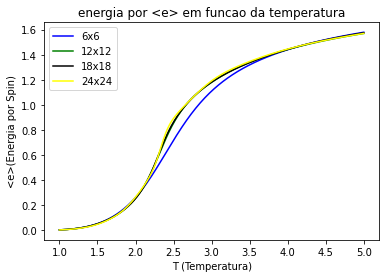

In [ ]:
show('energia por <e> em funcao da temperaturacaso

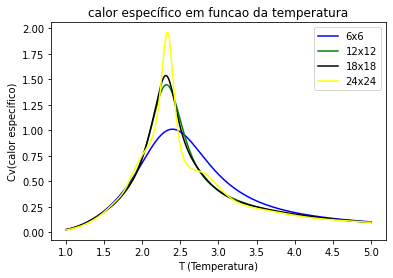

In [ ]:
show('calor específico em funcao da temperatura', 'T (Temperatura)', 'Cv(calor específico)', x_6, y_cv_6, x_12, y_cv_12, x_18, y_cv_18, x_24, y_cv_24)

**Discussão resultados 2** Podemos observar que os sistemas tiveram o maior calor específico quando t=2.25. Inicialmente a taxa de crescimento dos modelos são equivalenes mas logo os sistemas de maior quantidade crescem, tem um pico elevado e decresce igualmente até se aproximarem novamente em t>3.5.

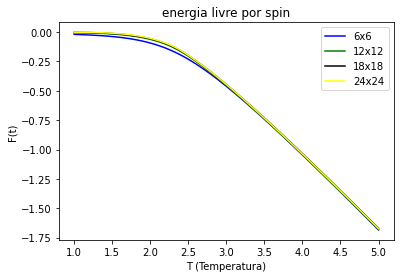

In [ ]:
show('energia livre por spin', 'T (Temperatura)', 'F(t)', x_6, y_ft_6, x_12, y_ft_12, x_18, y_ft_18, x_24, y_ft_24)

**Discussão resultados 3**
Diferentemente de da questão 1, a energia livre decresce quando se tem um aumento na temperatura. Além disso a taxa de decrescimento de ambos sistema são próximos mas cada um partindo de um f inicial diferente.

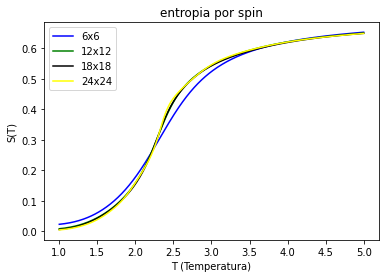

In [ ]:
show('entropia por spin', 'T (Temperatura)', 'S(T)', x_6, y_st_6, x_12, y_st_12, x_18, y_st_18, x_24, y_st_24)

**Discussão resultados 4**
A entropia é crescente quando há aumento de temperatura. É esperado que sistemas mais complexos tenham um grau de entropia maior e, por isso, a taxa de crescimento é mais alta para sistemas maiores.

#Q5

In [ ]:
mag_6 = magnetizacao_media(lnge_6,mmicro_6, N_6,t)

In [ ]:
mag_12 = magnetizacao_media(lnge_12,mmicro_12, N_12,t)

In [ ]:
mag_18 = magnetizacao_media(lnge_18,mmicro_18, N_18,t)

In [ ]:
mag_24 = magnetizacao_media(lnge_24,mmicro_24, N_24,t)

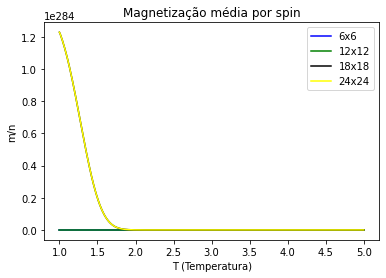

In [ ]:
show('Magnetização média por spin', 'T (Temperatura)', 'm/n', x_6, mag_6, x_12, mag_12, x_18, mag_18, x_24, mag_24)

**Discussão resultados 4** É esperado que um material, quando aumentado sua temperatura, a magnetização tende a 0. 